# Named Entity Recognition Experiment

### Report

### Setup environment

In [49]:
!pip install transformers modin matplotlib seaborn scikit-learn
!pip3 install -U scikit-learn bertviz

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [21]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizerFast, BertForTokenClassification

import modin.pandas as pd_modin
import time
import os
import matplotlib.pyplot as plt
import numpy as np
from bertviz import model_view
from transformers_interpret import TokenClassificationExplainer

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import unittest
# os.environ['MODIN_ENGINE'] = 'dask'
import random
# to ensure replicability
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

class Config:
    PRETRAINED = "prajjwal1/bert-tiny"
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    train_size_split, val_size_split, test_size_split = 0,0,0
    epochs = 3
    batch_size = 128
    
config = Config()

### Gather all functionalities in one cell

In [16]:
def load_data(filepath: str):
    """
    Load text dataset with entity tags
    """
    dataset = pd.read_csv(filepath).fillna(method='ffill')
    
    return dataset


def get_sentences_and_labels(dataset) -> ([], []):
    sentences, targets = [], []

    for sent_i, x in dataset.groupby("Sentence #"):
        words = x["Word"].tolist()
        tags = x["Tag"].tolist()
        sentences.append(words)
        targets.append(tags)

    return sentences, targets


def text_encoding_and_tokenizer(sentences, pretrained, max_len_sentence):
    """
    Convert each word into subwords and their respective subword ids such that Bert can work with the words
    """
    tokenizer = BertTokenizerFast.from_pretrained(pretrained)
    sentences_encoded = tokenizer(
        sentences, is_split_into_words=True, return_tensors="pt", 
        padding=True, truncation=True, max_length=max_len_sentence, add_special_tokens=False
    )
    return sentences_encoded, tokenizer


def target_encoding(targets, tag2idx):
    """
    Convert the NER tags into tensors such that Bert can work with them
    """
    num_sentences = len(targets)
    max_len = sentences_encoded["input_ids"].shape[1]
    # pre-allocating memory and using in-place operations the code run faster
    # Pre-allocate memory for the entire targets_encoded tensor 
    targets_encoded = torch.full((num_sentences, max_len), fill_value=tag2idx['O'], dtype=torch.long)

    for sent_idx, target in enumerate(targets):
        # repeat ner tag for each subword
        for word_idx, tag in enumerate(target):
            span = sentences_encoded.word_to_tokens(sent_idx, word_idx)
            # ignore words that tokenizer did not understand e.g. special characters
            if span is not None:
                start, end = span
                # Use in-place operation to update the tensor
                targets_encoded[sent_idx, start:end] = tag2idx[tag]

    print(targets_encoded.shape)
    return targets_encoded, tag2idx

    
class NERDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = sentences
        self.labels = labels

    def __getitem__(self, index):
        ids = torch.tensor(self.sentences[index].ids)
        mask = torch.tensor(self.sentences[index].attention_mask)
        labels = self.labels[index].clone()

        return {
            'ids': ids,
            'mask': mask,
            'tags': labels
        }

    def __len__(self):
        return len(self.labels)
        

@torch.no_grad()
def evaluate(model: torch.nn.Module, dataloader: DataLoader) -> (float, list):
    model.eval()
    
    losses = np.zeros(len(dataloader))
    all_preds, all_trues = [], []
    attentions = []

    for idx, data in enumerate(dataloader):
        data = {k: v.to(model.device) for k, v in data.items()}
        output = model(data["ids"], attention_mask=data["mask"], labels=data["tags"])
        loss = output[0]
        
        logits = output[1].detach().cpu()
        mask = data["mask"].cpu()
        label_ids = data["tags"].cpu()
        
        pred_ids = torch.argmax(logits, dim=-1)
        
        pred_ids_non_pad = pred_ids[mask==1] # remove pad predictions - deleted the for loop
        label_ids_non_pad = label_ids[mask==1]
        all_preds.append(pred_ids_non_pad)
        all_trues.append(label_ids_non_pad)

        attentions.append(output[2])
        losses[idx] = loss.detach().cpu().item()


    all_preds = torch.cat(all_preds)
    all_trues = torch.cat(all_trues)

    f1 = f1_score(all_trues, all_preds, average='micro') 

    return f1, losses, (all_preds, all_trues)


@torch.enable_grad()
def update(model: torch.nn.Module, trainloader: DataLoader) -> (float, list):
    model.train()
    device = next(model.parameters()).device
    
    epoch_train_losses = np.zeros(shape=len(trainloader))
    all_preds, all_trues = [], []
    
    for i, data in enumerate(trainloader, 0):
        data = {k: v.to(device) for k, v in data.items()}
        output = model(data["ids"], attention_mask=data["mask"], labels=data["tags"])
        loss = output[0]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_losses[i] = loss.detach().cpu().item()

        logits = output[1].detach().cpu()
        mask = data["mask"].cpu()
        label_ids = data["tags"].cpu()
        
        pred_ids = torch.argmax(logits, dim=-1)
        
        pred_ids_non_pad = pred_ids[mask==1] # remove pad predictions - deleted the for loop
        label_ids_non_pad = label_ids[mask==1]
        all_preds.append(pred_ids_non_pad)
        all_trues.append(label_ids_non_pad)

    all_preds = torch.cat(all_preds)
    all_trues = torch.cat(all_trues)

    f1 = f1_score(all_trues, all_preds, average='micro') 

    return f1, epoch_train_losses


def early_stopping(model, curr_validation_accuracy, counter=0, best_accuracy_so_far=None, delta=0, patience=5,):
        """
        Stops the training if validation accuracy doesn't improve after a given patience.
        """

        if best_accuracy_so_far is None:
            counter = 0
            best_accuracy_so_far = curr_validation_accuracy
            print(f"saving the model as bert_ner_{best_accuracy_so_far:.3f} ...")
            torch.save(model.state_dict(), f"bert_ner_{best_accuracy_so_far:.3f}")

        elif curr_validation_accuracy < best_accuracy_so_far + delta:
            counter += 1
            print(f'EarlyStopper counter: {counter} out of {patience} | {curr_validation_accuracy} < {best_accuracy_so_far + delta}')
            if counter >= patience:
                return True, counter, best_accuracy_so_far
        else:
            print(f'Val acc increased ({best_accuracy_so_far:.6f} --> {curr_validation_accuracy:.6f}),model saved as bert_ner.pt')
            best_accuracy_so_far = curr_validation_accuracy
            torch.save(model.state_dict(), f"bert_ner.pt")
            counter = 0

        return False, counter, best_accuracy_so_far

#### unittests

In [100]:
class TestNERFunctions(unittest.TestCase):

    def test_load_data(self):
        filepath = "ner.csv"
        data = load_data(filepath)
        
        self.assertIsInstance(data, pd.DataFrame)
        self.assertIn("Word", data.columns)
        self.assertIn("Tag", data.columns)

    def test_get_sentences_and_labels(self):
        dataset = load_data("ner.csv")
        sentences, targets = get_sentences_and_labels(dataset)
        
        self.assertIsInstance(sentences, list)
        self.assertIsInstance(targets, list)
        self.assertEqual(len(sentences), len(targets))

    def test_text_encoding_and_tokenizer(self):
        sentences = [["Hello", "world"], ["I", "am", "here"]]
        pretrained = "bert-base-uncased"
        max_len_sentence = 10
        encoded, tokenizer = text_encoding_and_tokenizer(sentences, pretrained, max_len_sentence)
  
        self.assertIn("input_ids", encoded)
        self.assertIsInstance(tokenizer, BertTokenizerFast)

    def test_target_encoding(self):
        targets = [["O", "B-PER"], ["B-LOC", "I-LOC", "O"]]
        tag2idx = {"O": 0, "B-PER": 1, "B-LOC": 2, "I-LOC": 3}
        encoded_targets, tag2idx_returned = target_encoding(targets, tag2idx)
        
        self.assertIsInstance(encoded_targets, torch.Tensor)
        self.assertEqual(encoded_targets.shape[0], len(targets))
        self.assertIsInstance(tag2idx_returned, dict)

suite = unittest.TestLoader().loadTestsFromTestCase(TestNERFunctions)
unittest.TextTestRunner(verbosity=2).run(suite)

test_get_sentences_and_labels (__main__.TestNERFunctions) ... ok
test_load_data (__main__.TestNERFunctions) ... ok
test_target_encoding (__main__.TestNERFunctions) ... ok
test_text_encoding_and_tokenizer (__main__.TestNERFunctions) ... ok

----------------------------------------------------------------------
Ran 4 tests in 2.717s

OK


torch.Size([2, 150])


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

### Load dataset

Load text dataset with entity tags


<span style="color:red;">**modifications**</span>

- load csv with modin packge (mimics `with multiprocessing`), it will spead up the csv loading significantly

In [3]:
dataset = load_data("ner.csv")

sentences, targets = get_sentences_and_labels(dataset)

dataset.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


### Data visualization

Number of sentences in dataset

In [4]:
dataset.Tag.nunique(), len(sentences), len(targets)

(17, 22862, 22862)

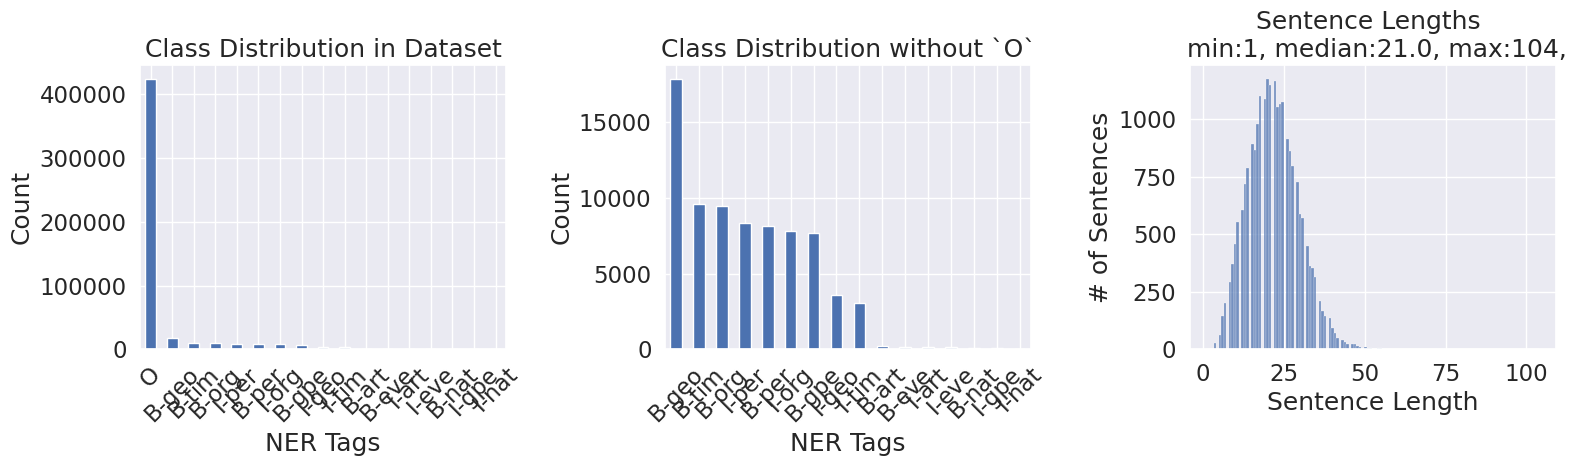

In [5]:
tag_counts = dataset['Tag'].value_counts()
lengths = [len(i) for i in sentences]

# Set the style and size
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.figure(figsize=(16, 5))

# First subplot: classes distribution
plt.subplot(1, 3, 1)
tag_counts.plot(kind='bar')
plt.title('Class Distribution in Dataset')
plt.xlabel('NER Tags')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(1, 3, 2)
tag_counts.drop('O').plot(kind='bar')
# tag_counts.drop('O').plot(kind='pie', autopct='%1.1f%%', startangle=90, legend=False, figsize=(20, 8))
plt.title('Class Distribution without `O`')
plt.xlabel('NER Tags')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Second subplot: to understand the best max_len_sentence in tokenizer
plt.subplot(1, 3, 3)
sns.histplot(lengths, kde=False)
plt.xlabel('Sentence Length')
plt.ylabel('# of Sentences')
plt.title(f"Sentence Lengths \n min:{min(lengths)}, median:{np.median(lengths)}, max:{max(lengths)},")
plt.tight_layout()

plt.show()

In [6]:
tag_counts = dataset['Tag'].value_counts()
tag_counts

Tag
O        423645
B-geo     17839
B-tim      9563
B-org      9453
I-per      8354
B-per      8106
I-org      7791
B-gpe      7695
I-geo      3583
I-tim      3044
B-art       203
B-eve       181
I-art       155
I-eve       145
B-nat       105
I-gpe       103
I-nat        34
Name: count, dtype: int64

### Text encoding

Convert each word into subwords and their respective subword ids such that Bert can work with the words

In [7]:
# tokenize words
sentences_encoded, tokenizer = text_encoding_and_tokenizer(sentences, config.PRETRAINED, max_len_sentence=150)
sentences_encoded["input_ids"].shape

torch.Size([22862, 150])

### Target encoding

Convert the NER tags into tensors such that Bert can work with them

In [8]:
# mapping from ner tag to number
tag2idx = {tag: i for i, tag in enumerate(set(t for ts in targets for t in ts))}
tag2idx

{'B-org': 0,
 'B-eve': 1,
 'B-tim': 2,
 'O': 3,
 'I-per': 4,
 'B-art': 5,
 'I-art': 6,
 'B-geo': 7,
 'I-org': 8,
 'B-nat': 9,
 'I-gpe': 10,
 'B-per': 11,
 'I-eve': 12,
 'I-nat': 13,
 'B-gpe': 14,
 'I-tim': 15,
 'I-geo': 16}

Pad the target tensors because sentences have different length

In [9]:
"""
code snippet runtime was optimized by using memory pre-allocation and in-place operations.

profiling of orignal code below:
CPU times: user 42.3 s, sys: 322 ms, total: 42.6 s
Wall time: 42.9 s

torch.Size([22862, 110])
"""

'\ncode snippet runtime was optimized by using memory pre-allocation and in-place operations.\n\nprofiling of orignal code below:\nCPU times: user 42.3 s, sys: 322 ms, total: 42.6 s\nWall time: 42.9 s\n\ntorch.Size([22862, 110])\n'

In [10]:
%%time
targets_encoded, _ = target_encoding(targets, tag2idx)
targets_encoded.shape

torch.Size([22862, 150])
CPU times: user 4.25 s, sys: 17.8 ms, total: 4.27 s
Wall time: 4.35 s


torch.Size([22862, 150])

Show the first sample and its target tensor

In [11]:
tokenizer.decode(sentences_encoded["input_ids"][0])

'thousands of demonstrators have marched through london to protest the war in iraq and demand the withdrawal of british troops from that country. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [12]:
targets_encoded[:1]

tensor([[ 3,  3,  3,  3,  3,  3,  7,  3,  3,  3,  3,  3,  7,  3,  3,  3,  3,  3,
         14,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3]])

### Train/Test split

Split dataset into training and test set


<span style="color:red;">**modifications**</span>


- adding the validation set useful for parameters tuning
- [note todo] we could look up the class distribution in each set and provide a more balanced splitting of classes

In [13]:
num_sentences = len(sentences_encoded.input_ids)
train_size, val_size, test_size = int(0.8 * num_sentences), int(0.1 * num_sentences), int(0.1 * num_sentences)

train_sentences = sentences_encoded[:train_size]
train_targets = targets_encoded[:train_size]
test_sentences = sentences_encoded[train_size:train_size+test_size]
test_targets = targets_encoded[train_size:train_size+test_size]
val_sentences = sentences_encoded[train_size+test_size:]
val_targets = targets_encoded[train_size+test_size:]

print(f"\tTrain sentences: {len(train_targets)}", f"\n\tVal sentences: {len(val_targets)}", f"\n\tTest sentences: {len(test_targets)}")

training_set = NERDataset(train_sentences, train_targets)
val_set = NERDataset(val_sentences, val_targets)
testing_set = NERDataset(test_sentences, test_targets)

training_loader = DataLoader(training_set, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=config.batch_size, shuffle=False)
testing_loader = DataLoader(testing_set, batch_size=config.batch_size, shuffle=False)

	Train sentences: 18289 
	Val sentences: 2287 
	Test sentences: 2286


## Train model

Load a pretrained Bert model to fine-tune for multi-class classification of NER tags

<span style="color:red;">**modifications**</span>


- use numpy array of list for speed and resources optimization - look up here link why ()
- slit data into train/val/test
- use cross validation - if data is not much
- add early stopping
- look up attention values by setting output_attentions=True - useful for explananibility later on
- [note] grid search

In [17]:
del model

In [18]:
model = BertForTokenClassification.from_pretrained(config.PRETRAINED, num_labels=len(tag2idx), output_attentions=True)
model = model.to(config.device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-05)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


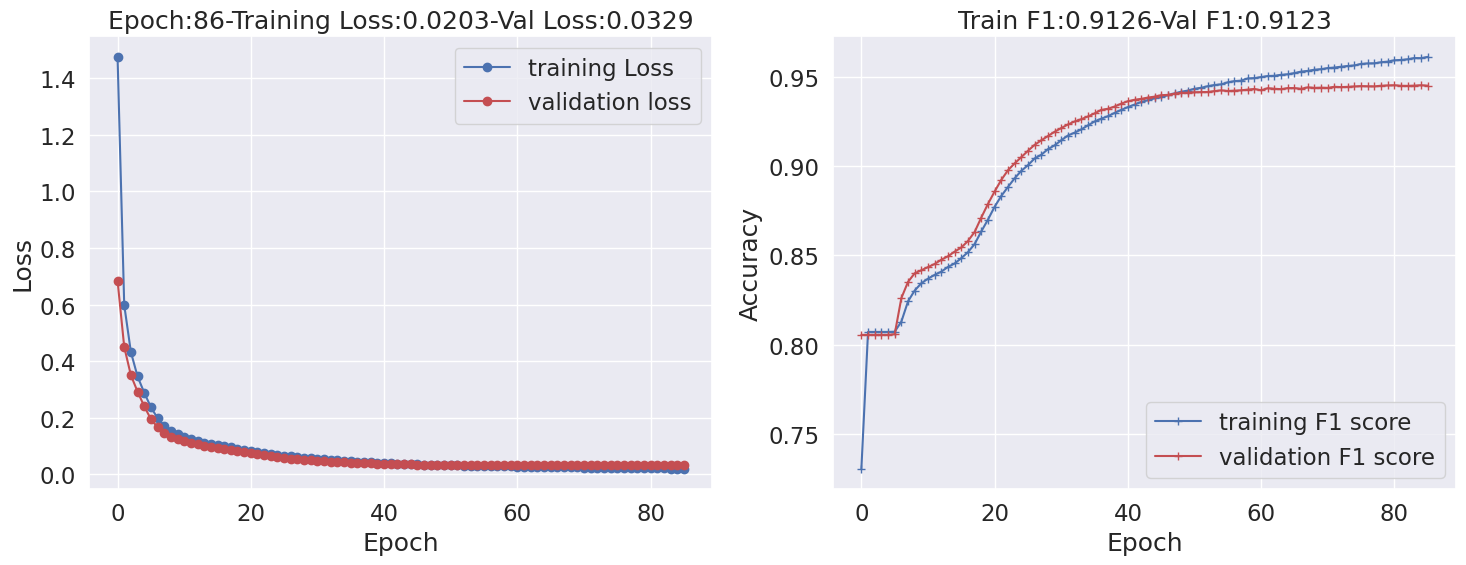

EarlyStopper counter: 5 out of 5 | 0.9453774691079643 < 0.9456119779922432
Early stopping triggered. Training stopped.


51683

In [19]:
counter, best_accuracy_so_far = 0, 0

all_epoch_train_losses, all_epoch_val_losses = [], []
epochs_val_f1_scores, epochs_train_f1_scores = [], []

# training loop
for epoch in range(1, 200):
    
    train_f1_score, epoch_train_losses = update(model, training_loader)
    all_epoch_train_losses.append(epoch_train_losses.mean())
    epochs_train_f1_scores.append(train_f1_score)

    val_f1, val_loss, _ = evaluate(model, val_loader)
    all_epoch_val_losses.append(val_loss.mean())
    epochs_val_f1_scores.append(val_f1)
    
    clear_output(wait=True)  # Clear the previous plot
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(all_epoch_train_losses, 'b-o', label='training Loss')
    plt.plot(all_epoch_val_losses, 'r-o', label="validation loss")
    plt.title(f"Epoch:{epoch}-Training Loss:{epoch_train_losses.mean():.4f}-Val Loss:{val_loss.mean():.4f}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_train_f1_scores, 'b-+', label='training F1 score')
    plt.plot(epochs_val_f1_scores, 'r-+', label='validation F1 score')
    plt.title(f"Train F1:{np.mean(epochs_train_f1_scores):.4f}-Val F1:{np.mean(epochs_val_f1_scores):.4f}")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()

    plt.show()

    do_early_stopping, counter, best_accuracy_so_far = early_stopping(model, val_f1, counter=counter, best_accuracy_so_far=best_accuracy_so_far)
    if do_early_stopping:
        print("Early stopping triggered. Training stopped.")
        break

import gc
gc.collect()

## Test model

Compute classification metric of Bert model on test set


<span style="color:red;">**modifications**</span>

In [34]:
idx2tag = {v:k for k, v in tag2idx.items()}

In [24]:
testset_f1, testset_loss, (predictions, labels) = evaluate(model, testing_loader)
print(f"\tTest Accuracy: {testset_f1:.3f}\n")
print("\tTest classification report:\n\n {}".format(classification_report(predictions, labels, digits=4)))

	Test Accuracy: 0.942

	Test classification report:

               precision    recall  f1-score   support

           0     0.5889    0.6703    0.6270      1374
           1     0.3000    0.7500    0.4286         8
           2     0.8475    0.8738    0.8605       935
           3     0.9873    0.9784    0.9828     45688
           4     0.8447    0.7941    0.8187      1569
           5     0.0000    0.0000    0.0000         0
           6     0.0000    0.0000    0.0000         0
           7     0.8425    0.7921    0.8166      2776
           8     0.5164    0.6157    0.5617       765
           9     0.2500    0.2000    0.2222        15
          10     0.0000    0.0000    0.0000         0
          11     0.7802    0.7867    0.7834      1191
          12     0.1000    1.0000    0.1818         1
          13     0.0000    0.0000    0.0000         0
          14     0.8747    0.9433    0.9077       829
          15     0.6408    0.7857    0.7059       252
          16     0.6414    

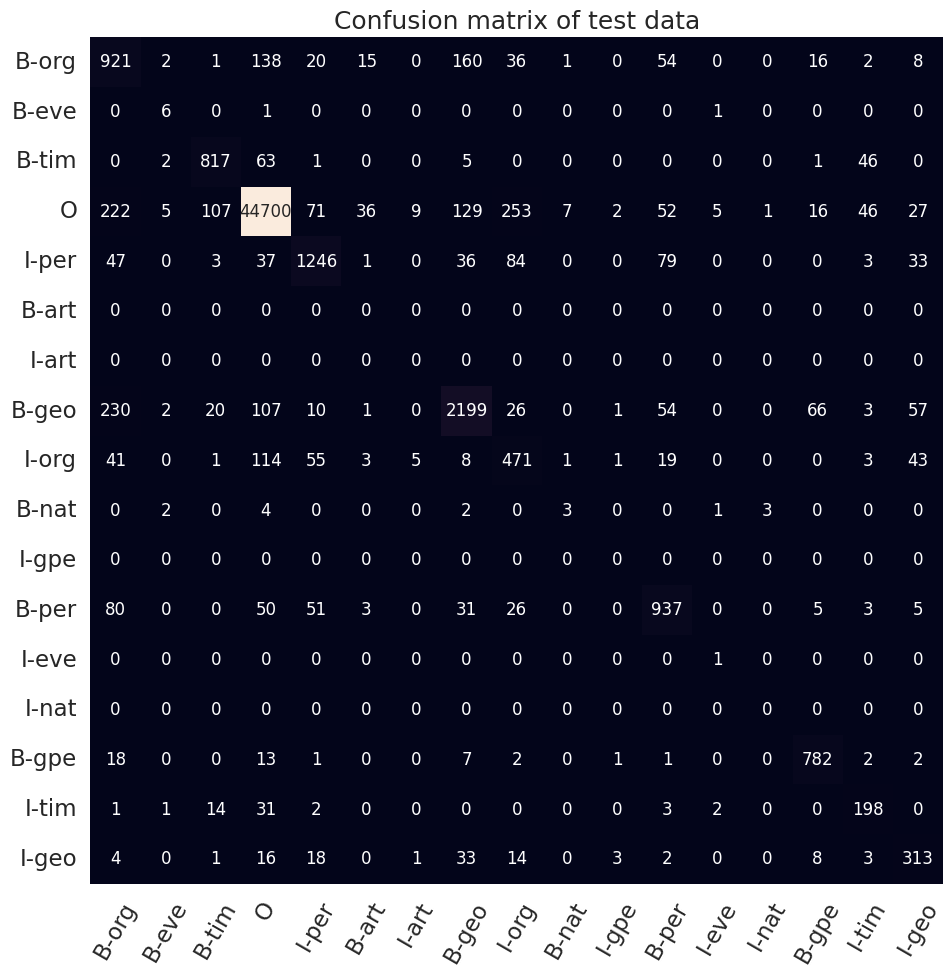

In [28]:
cm = confusion_matrix(predictions, labels)
plt.figure(figsize = (11, 11))
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True,annot_kws={"size": 12}, cbar=False, fmt='g', xticklabels=tag2idx.keys(), yticklabels=tag2idx.keys())
plt.title("Confusion matrix of test data")
plt.xticks(rotation=60)
plt.show()

## <span style="color:red;">Model Explanability </span>

- Pick a sentence that the model classifies all token correctly
- pick another one which is more challenging
- look up the attention values in each of those sentences and see which tokens influnce the decision

In [85]:
model.eval()
for idx in range(len(testing_set)):
    data = testing_set[idx]
    data = {k: v.unsqueeze(0).to(model.device) for k, v in data.items()}
    output = model(data["ids"], attention_mask=data["mask"], labels=data["tags"]) 
    logits = output[1].detach().cpu()
    mask = data["mask"].cpu()
    label_ids = data["tags"].cpu()
    pred_ids = torch.argmax(logits, dim=-1)
    pred_ids_non_pad = pred_ids[mask==1] #
    acc = f1_score(pred_ids_non_pad, label_ids[mask==1], average='micro') 
    if acc < 0.5:
        print(f"{idx}:{acc:.3f}")

1365:0.474
1660:0.476
1896:0.424


In [66]:
input_text = "The cat sat on the mat"  
inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
outputs = model(inputs.to(model.device))  # Run model
attention = outputs['attentions']  # Retrieve attention from model outputs
# print(attention)
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
model_view(attention, tokens)  # Display model view - taken from: https://github.com/jessevig/bertviz

<IPython.core.display.Javascript object>

**easy example**

In [88]:
ner_explainer = TokenClassificationExplainer(model=model, tokenizer=tokenizer)
sample_text = tokenizer.decode(testing_set[0]['ids'][testing_set[0]['mask'] == 1])
true_labels = [13] + testing_set[0]['tags'][testing_set[0]['mask'] == 1].tolist() + [13]
attributions = ner_explainer(sample_text)
ner_explainer.visualize(true_classes=true_labels)

**challenging example**  

In [87]:
ner_explainer = TokenClassificationExplainer(model=model, tokenizer=tokenizer)
idx = 1896
sample_text = tokenizer.decode(testing_set[idx]['ids'][testing_set[idx]['mask'] == 1])
true_labels = [13] + testing_set[idx]['tags'][testing_set[idx]['mask'] == 1].tolist() + [13]
attributions = ner_explainer(sample_text)
ner_explainer.visualize(true_classes=true_labels)